In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [2]:
SINGLE_SPEECH_DATASET = "https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.01.tar.gz"
DATASET_PATH = "data/"

data_dir = pathlib.Path(DATASET_PATH)

tf.keras.utils.get_file(
    'speech_commands.zip',
    origin = SINGLE_SPEECH_DATASET,
    extract = True,
    cache_dir = ".",
    cache_subdir = "data"
)

1489096277/1489096277 ━━━━━━━━━━━━━━━━━━━━ 65s 0us/step


'./data/speech_commands.zip'

In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory = data_dir,
    batch_size = 64,
    validation_split = 0.2,
    seed = 0,
    output_sequence_length = 16000,
    subset = "both"
)

label_names = np.array(train_ds.class_names)
print("Label Names: ", label_names)

Found 64727 files belonging to 31 classes.
Using 51782 files for training.
Using 12945 files for validation.
Label Names:  ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


In [5]:
for audio, label in train_ds.take(1):
    print("Original Audio Shape : ", audio.shape)
    print("Audio : ", audio)
    print("Label : ", label)

Original Audio Shape :  (64, 16000, 1)
Audio :  tf.Tensor(
[[[ 4.8828125e-04]
  [ 4.8828125e-04]
  [ 3.9672852e-04]
  ...
  [ 3.2958984e-03]
  [ 2.2277832e-03]
  [ 1.9531250e-03]]

 [[ 3.0517578e-05]
  [ 6.1035156e-05]
  [ 6.1035156e-05]
  ...
  [ 3.0517578e-05]
  [ 6.1035156e-05]
  [-3.0517578e-05]]

 [[ 1.8310547e-04]
  [ 4.3029785e-03]
  [ 3.6010742e-03]
  ...
  [ 2.3193359e-03]
  [ 3.6315918e-03]
  [ 5.3405762e-03]]

 ...

 [[-6.5612793e-03]
  [-6.8664551e-03]
  [-6.5002441e-03]
  ...
  [-8.0566406e-03]
  [-1.2145996e-02]
  [-1.2939453e-02]]

 [[ 7.6293945e-04]
  [ 7.0190430e-04]
  [ 7.6293945e-04]
  ...
  [-6.1035156e-04]
  [-9.4604492e-04]
  [-1.0375977e-03]]

 [[-7.0190430e-04]
  [-6.1035156e-05]
  [ 6.1035156e-04]
  ...
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]]], shape=(64, 16000, 1), dtype=float32)
Label :  tf.Tensor(
[24 22 23  5 17  8  5 19 13 10 27 26 18 10 26 10  5 13  2 16  2  2 30 28
 21 20 18 16  2  5 23 27 24  8 15 13 26 30 30 24  9 29  9  8 20  5  1 19

# Preprocess

In [6]:
# Buang 1 dari : (64, 16000, 1)
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis = -1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


In [7]:
# bagi validation dan test datasets
# 80% training, 10% validation, 10% test
test_ds = val_ds.shard(num_shards = 2, index = 0)
val_ds = val_ds.shard(num_shards = 2, index = 1)

In [8]:
for audio, labels, in train_ds.take(1):
  spectrogram = tf.signal.stft(audio, frame_length = 255, frame_step = 128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  print(spectrogram.shape)

(64, 124, 129, 1)


In [9]:
def get_spectrogram(audio):
  spectrogram = tf.signal.stft(audio, frame_length = 255, frame_step = 128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [10]:
def make_spec_ds(ds):
  return ds.map(map_func = lambda audio, label: (get_spectrogram(audio), label), num_parallel_calls = tf.data.AUTOTUNE)

In [11]:
train_spectrogram_ds = make_spec_ds(train_ds)
test_spectrogram_ds = make_spec_ds(test_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

In [12]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [13]:
for sample_spectrogram, sample_labels in train_spectrogram_ds.take(1):
  break

In [14]:
# Arsitektur CNN
input_shape = sample_spectrogram.shape[1:]
num_labels = len(label_names)

# Normalization Layer
norm_layer = layers.Normalization()
norm_layer.adapt(data = train_spectrogram_ds.map(map_func = lambda spec, label:spec))

model = models.Sequential(
    [
        layers.Input(shape = input_shape),
        layers.Resizing(32, 32),
        norm_layer,
        layers.Conv2D(32, 3, activation = 'relu'),
        layers.Conv2D(64, 3, activation = 'relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation = 'relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels)
    ]
)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 31)                  │           3,999 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,628,578 (6.21 MB)

 Trainable params: 1,628,575 (6.21 MB)

 Non-trainable params: 3 (16.00 B)

In [16]:
model.compile(
    metrics = ['accuracy'],
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = tf.keras.optimizers.Adam()
)

In [17]:
EPOCHS = 10

history = model.fit(
    train_spectrogram_ds,
    validation_data = val_spectrogram_ds,
    epochs = EPOCHS,
    callbacks = tf.keras.callbacks.EarlyStopping(verbose = 1, patience = 2)
)

Epoch 1/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.2475 - loss: 2.6756 - val_accuracy: 0.6954 - val_loss: 1.1143
Epoch 2/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.6181 - loss: 1.2829 - val_accuracy: 0.7789 - val_loss: 0.7933
Epoch 3/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6999 - loss: 1.0021 - val_accuracy: 0.8111 - val_loss: 0.6625
Epoch 4/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7440 - loss: 0.8550 - val_accuracy: 0.8260 - val_loss: 0.6085
Epoch 5/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7652 - loss: 0.7688 - val_accuracy: 0.8410 - val_loss: 0.5483
Epoch 6/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7836 - loss: 0.6987 - val_accuracy: 0.8521 - val_loss: 0.5202
Epoch 7/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7989 - loss: 0.6389 - val_accuracy: 0.8549 - val_loss: 0.4990
Epoch 8/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8161 - loss: 0.5886 - val_accura

Text(0, 0.5, 'Accuracy [%]')

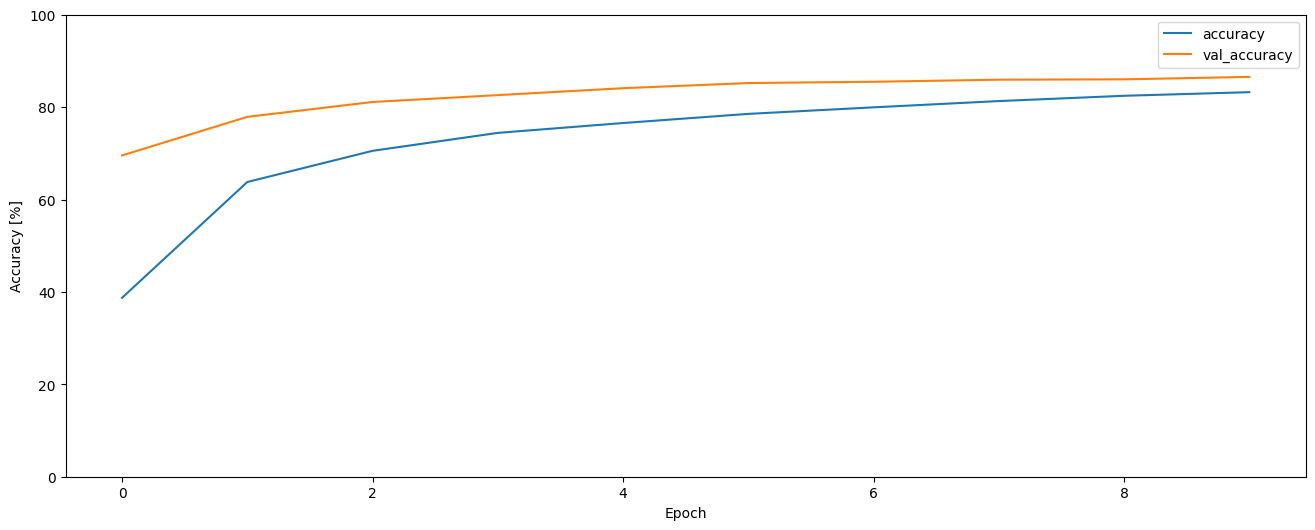

In [18]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")

In [19]:
# Get Model Predictions
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step


In [20]:
def convert_to_label(labels):
  return [ label_names[label.numpy()] for label in labels ]

y_pred = convert_to_label(y_pred)
y_true = convert_to_label(tf.concat([label for _, label in test_spectrogram_ds], axis=0))

for idx, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
  print(f'Data {idx} : Original Label {true_label}, Prediction {pred_label}')

Streaming output truncated to the last 5000 lines.
Data 1481 : Original Label two, Prediction two
Data 1482 : Original Label off, Prediction off
Data 1483 : Original Label happy, Prediction happy
Data 1484 : Original Label stop, Prediction stop
Data 1485 : Original Label dog, Prediction dog
Data 1486 : Original Label tree, Prediction tree
Data 1487 : Original Label go, Prediction down
Data 1488 : Original Label one, Prediction one
Data 1489 : Original Label nine, Prediction nine
Data 1490 : Original Label up, Prediction up
Data 1491 : Original Label left, Prediction left
Data 1492 : Original Label off, Prediction off
Data 1493 : Original Label wow, Prediction one
Data 1494 : Original Label dog, Prediction up
Data 1495 : Original Label house, Prediction house
Data 1496 : Original Label tree, Prediction tree
Data 1497 : Original Label two, Prediction two
Data 1498 : Original Label nine, Prediction nine
Data 1499 : Original Label house, Prediction house
Data 1500 : Original Label left, Pr

In [22]:
model.save("speech_model.keras")